# Multilabel Text Classification: Toxic Comment Detection

## Overview

This notebook demonstrates a complete **multilabel text classification** pipeline. We identify multiple types of toxicity in comments using multiple feature engineering techniques and machine learning algorithms.

---

### What is Multilabel Classification?

Multilabel classification allows **multiple labels to be assigned** to each document simultaneously.

| Type | Description | Example | Labels per Document |
|------|-------------|---------|--------------------|
| **Multilabel** | Multiple labels can be assigned | Content tags | 0 to many |

### Pipeline

```
Raw Text → Cleaning → Preprocessing → Feature Engineering → Model Training → Evaluation
```

### Feature Methods: CountVectorizer, TF-IDF, Word2Vec (BM25 skipped due to runtime)
### Algorithms: Naive Bayes, Logistic Regression, SVM, Random Forest
### All classifiers wrapped in `OneVsRestClassifier` for multilabel support

---

In [1]:
# =============================================================================
# INSTALLATION
# =============================================================================
# Uncomment and run if packages are not installed:

# !pip install pandas numpy scikit-learn matplotlib seaborn
# !pip install nltk rank_bm25 gensim sentence-transformers
#!pip install tf-keras

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

# Data manipulation
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords

# Feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from rank_bm25 import BM25Okapi
import gensim.downloader as api


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    hamming_loss, jaccard_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
import warnings
import time
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Download NLTK data
nltk.download('stopwords', quiet=True)

print("All libraries imported successfully!")

All libraries imported successfully!


---

<a id='cleaning'></a>
## 3. Data Cleaning

### Why Clean Text?

Raw text data often contains noise that doesn't contribute to classification:
- HTML tags from web scraping
- URLs and email addresses
- Excessive whitespace
- Special characters

Cleaning removes this noise to improve model performance.

### Cleaning Methods Used

| Method | What it does | Example |
|--------|--------------|--------|
| Remove HTML | Strips `<tag>` elements | `<p>Hello</p>` → `Hello` |
| Remove URLs | Removes web links | `Check http://x.com` → `Check` |
| Remove Emails | Removes email addresses | `Contact a@b.com` → `Contact` |
| Normalize Whitespace | Collapses multiple spaces | `Hello    world` → `Hello world` |

In [3]:
# =============================================================================
# DATA CLEANING FUNCTION
# =============================================================================

def clean_text(text):
    """
    Clean raw text by removing noise.
    
    Steps:
        1. Remove HTML tags (e.g., <p>, <div>, <br>)
        2. Remove URLs (http://, https://, www.)
        3. Remove email addresses
        4. Normalize whitespace (multiple spaces → single space)
    
    Parameters:
        text (str): Raw text string
    
    Returns:
        str: Cleaned text string
    
    Example:
        >>> clean_text("<p>Visit http://example.com or email test@mail.com</p>")
        'Visit or email'
    """
    # Handle missing values
    if pd.isna(text):
        return ""
    
    # Convert to string
    text = str(text)
    
    # Step 1: Remove HTML tags
    # Pattern: <anything> where anything doesn't contain >
    text = re.sub(r'<[^>]+>', '', text)
    
    # Step 2: Remove URLs
    # Pattern: http(s):// or www. followed by non-whitespace
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Step 3: Remove email addresses
    # Pattern: something@something.something
    text = re.sub(r'\S+@\S+', '', text)
    
    # Step 4: Normalize whitespace
    # Replace multiple spaces/tabs/newlines with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [4]:
# =============================================================================
# TEST CLEANING FUNCTION
# =============================================================================

# Example with various noise types
test_dirty = """
<html><body>
<p>Hello! Check out http://example.com for more info.</p>
<p>Contact us at support@company.com or visit www.company.com</p>
</body></html>
"""

print("BEFORE CLEANING:")
print("-" * 50)
print(test_dirty)
print("\nAFTER CLEANING:")
print("-" * 50)
print(clean_text(test_dirty))

BEFORE CLEANING:
--------------------------------------------------

<html><body>
<p>Hello! Check out http://example.com for more info.</p>
<p>Contact us at support@company.com or visit www.company.com</p>
</body></html>


AFTER CLEANING:
--------------------------------------------------
Hello! Check out for more info. Contact us at or visit


---

<a id='preprocessing'></a>
## 4. Text Preprocessing

### Why Preprocess?

After cleaning, we standardize the text to reduce vocabulary size and focus on meaningful words.

### Preprocessing Methods Used

| Method | What it does | Example |
|--------|--------------|--------|
| Lowercasing | Converts to lowercase | `Hello WORLD` → `hello world` |
| Stopword Removal | Removes common words | `the cat is here` → `cat here` |

### What are Stopwords?

Stopwords are common words that appear frequently but carry little meaning:
- Articles: the, a, an
- Prepositions: in, on, at, to
- Conjunctions: and, but, or
- Pronouns: he, she, it, they

Removing them reduces noise and feature dimensionality.

In [5]:
# =============================================================================
# TEXT PREPROCESSING FUNCTION
# =============================================================================

# Load English stopwords once
STOP_WORDS = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess cleaned text for feature extraction.
    
    Steps:
        1. Convert to lowercase
        2. Remove stopwords
    
    Parameters:
        text (str): Cleaned text string
    
    Returns:
        str: Preprocessed text string
    
    Example:
        >>> preprocess_text("The Quick Brown Fox Jumps Over The Lazy Dog")
        'quick brown fox jumps lazy dog'
    """
    # Step 1: Convert to lowercase
    text = text.lower()
    
    # Step 2: Tokenize and remove stopwords
    tokens = text.split()
    tokens = [token for token in tokens if token not in STOP_WORDS]
    
    return ' '.join(tokens)


def full_preprocess(text):
    """
    Apply full preprocessing pipeline: cleaning + preprocessing.
    
    Parameters:
        text (str): Raw text string
    
    Returns:
        str: Fully preprocessed text string
    """
    return preprocess_text(clean_text(text))

In [6]:
# =============================================================================
# TEST PREPROCESSING FUNCTION
# =============================================================================

test_text = "The Quick Brown Fox Jumps Over The Lazy Dog"

print("BEFORE PREPROCESSING:")
print(f"  '{test_text}'")
print(f"  Word count: {len(test_text.split())}")

print("\nAFTER PREPROCESSING:")
processed = preprocess_text(test_text)
print(f"  '{processed}'")
print(f"  Word count: {len(processed.split())}")

print("\nSTOPWORDS REMOVED:")
removed = set(test_text.lower().split()) - set(processed.split())
print(f"  {removed}")

BEFORE PREPROCESSING:
  'The Quick Brown Fox Jumps Over The Lazy Dog'
  Word count: 9

AFTER PREPROCESSING:
  'quick brown fox jumps lazy dog'
  Word count: 6

STOPWORDS REMOVED:
  {'over', 'the'}


---

<a id='feature-engineering'></a>
## 5. Feature Engineering Methods

### Why Feature Engineering?

Machine learning algorithms require numerical input. Feature engineering converts text into numerical vectors (arrays of numbers).

### Overview of Methods

| Method | Type | Vector Size | Captures Semantics? | Speed |
|--------|------|-------------|---------------------|-------|
| CountVectorizer | Sparse | Vocabulary size | No | Fast |
| TF-IDF | Sparse | Vocabulary size | No | Fast |
| BM25 | Dense | Corpus size | No | Medium |
| Word2Vec | Dense | 300 | Yes (word-level) | Medium |

### Sparse vs Dense Vectors

- **Sparse**: Most values are zero (bag-of-words methods)
- **Dense**: Most values are non-zero (embedding methods)

### 5.1 CountVectorizer (Bag of Words)

#### How it Works

CountVectorizer converts text into a matrix of word counts:

1. Build vocabulary from all documents
2. For each document, count occurrences of each word
3. Result: Document-term matrix

#### Example

```
Documents:
  Doc1: "cat sat mat"
  Doc2: "dog sat mat"

Vocabulary: [cat, dog, mat, sat]

Matrix:
       cat  dog  mat  sat
Doc1:   1    0    1    1
Doc2:   0    1    1    1
```

#### Pros and Cons

| Pros | Cons |
|------|------|
| Simple and interpretable | Ignores word order |
| Fast computation | High dimensionality |
| Works well as baseline | No semantic meaning |

In [7]:
# =============================================================================
# COUNTVECTORIZER FUNCTIONS
# =============================================================================

def create_count_features(train_texts, test_texts, max_features=5000):
    """
    Create bag-of-words features using CountVectorizer.
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
        max_features (int): Maximum vocabulary size (default: 5000)
    
    Returns:
        tuple: (X_train, X_test, vectorizer)
            - X_train: Sparse matrix of training features
            - X_test: Sparse matrix of test features
            - vectorizer: Fitted CountVectorizer object
    
    Example:
        >>> X_train, X_test, vec = create_count_features(train, test)
        >>> print(X_train.shape)  # (n_samples, n_features)
    """
    # Initialize vectorizer
    # ngram_range=(1,2) includes unigrams and bigrams
    vectorizer = CountVectorizer(
        max_features=max_features,
        ngram_range=(1, 2)
    )
    
    # Fit on training data, transform both
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    
    print(f"CountVectorizer:")
    print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test, vectorizer

### 5.2 TF-IDF (Term Frequency - Inverse Document Frequency)

#### How it Works

TF-IDF weighs words by importance:

- **TF (Term Frequency)**: How often a word appears in a document
- **IDF (Inverse Document Frequency)**: How rare a word is across all documents

```
TF-IDF = TF × IDF

TF = count(word in doc) / total words in doc
IDF = log(total docs / docs containing word)
```

#### Why TF-IDF?

Words that appear frequently in one document but rarely in others get higher scores:
- "Machine learning" in a tech article → High score
- "The" appearing everywhere → Low score

#### Pros and Cons

| Pros | Cons |
|------|------|
| Weighs important words | Still ignores word order |
| Reduces impact of common words | High dimensionality |
| Industry standard baseline | No semantic meaning |

In [8]:
# =============================================================================
# TF-IDF FUNCTIONS
# =============================================================================

def create_tfidf_features(train_texts, test_texts, max_features=5000):
    """
    Create TF-IDF weighted features.
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
        max_features (int): Maximum vocabulary size (default: 5000)
    
    Returns:
        tuple: (X_train, X_test, vectorizer)
            - X_train: Sparse matrix of training features
            - X_test: Sparse matrix of test features
            - vectorizer: Fitted TfidfVectorizer object
    
    Example:
        >>> X_train, X_test, vec = create_tfidf_features(train, test)
        >>> print(X_train.shape)  # (n_samples, n_features)
    """
    # Initialize vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2)
    )
    
    # Fit on training data, transform both
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    
    print(f"TF-IDF:")
    print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test, vectorizer

### 5.3 BM25 (Best Matching 25)

#### How it Works

BM25 is a ranking function used in information retrieval. It improves on TF-IDF by:

1. **Term frequency saturation**: Diminishing returns for repeated words
2. **Document length normalization**: Longer documents don't get unfair advantage

#### Formula

```
BM25(D, Q) = Σ IDF(qi) × (f(qi, D) × (k1 + 1)) / (f(qi, D) + k1 × (1 - b + b × |D|/avgdl))

Where:
  - k1 = term frequency saturation (typically 1.2-2.0)
  - b = length normalization (typically 0.75)
  - avgdl = average document length
```

#### Usage for Classification

We use each document as a query against the corpus to create document vectors.

#### Pros and Cons

| Pros | Cons |
|------|------|
| Better than raw TF-IDF | Requires tuning k1, b |
| Handles document length | Slower than TF-IDF |
| Industry standard in search | Dense output (corpus-sized) |

In [9]:
# =============================================================================
# BM25 FUNCTIONS
# =============================================================================

def create_bm25_features(train_texts, test_texts):
    """
    Create BM25-based document similarity features.
    
    How it works:
        1. Tokenize all documents
        2. Fit BM25 on training corpus
        3. For each document, compute BM25 scores against training corpus
        4. Result: Each document represented by its similarity to training docs
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
    
    Returns:
        tuple: (X_train, X_test, bm25_model)
            - X_train: Dense array of training features (n_train, n_train)
            - X_test: Dense array of test features (n_test, n_train)
            - bm25_model: Fitted BM25Okapi object
    
    Example:
        >>> X_train, X_test, bm25 = create_bm25_features(train, test)
        >>> print(X_train.shape)  # (n_train, n_train)
    """
    # Tokenize documents (BM25 expects list of token lists)
    train_tokenized = [doc.split() for doc in train_texts]
    test_tokenized = [doc.split() for doc in test_texts]
    
    # Fit BM25 on training corpus
    bm25_model = BM25Okapi(train_tokenized)
    
    # Create feature vectors
    # Each document gets scores against all training documents
    X_train = np.array([bm25_model.get_scores(doc) for doc in train_tokenized])
    X_test = np.array([bm25_model.get_scores(doc) for doc in test_tokenized])
    
    print(f"BM25:")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test, bm25_model

### 5.4 Word2Vec Embeddings

#### How it Works

Word2Vec learns dense vector representations of words from large text corpora:

1. Words with similar meanings have similar vectors
2. Vector arithmetic captures relationships: king - man + woman ≈ queen
3. For documents, we average word vectors

#### Pre-trained Model

We use Google's pre-trained Word2Vec model:
- Trained on Google News (~100 billion words)
- 3 million words and phrases
- 300-dimensional vectors

#### Pros and Cons

| Pros | Cons |
|------|------|
| Captures word semantics | Averaging loses word order |
| Dense, fixed-size vectors | No OOV (out-of-vocabulary) handling |
| Transfer learning from large corpus | Large model download (~1.6GB) |

In [10]:
# =============================================================================
# WORD2VEC FUNCTIONS
# =============================================================================

# Global variable to store loaded model (load once, use many times)
WORD2VEC_MODEL = None

def load_word2vec_model():
    """
    Load pre-trained Word2Vec model.
    
    Downloads Google News Word2Vec model on first call (~1.6GB).
    Subsequent calls return cached model.
    
    Returns:
        gensim.models.KeyedVectors: Pre-trained Word2Vec model
    """
    global WORD2VEC_MODEL
    if WORD2VEC_MODEL is None:
        print("Loading Word2Vec model (this may take a few minutes on first run)...")
        WORD2VEC_MODEL = api.load('word2vec-google-news-300')
        print(f"Loaded! Vocabulary size: {len(WORD2VEC_MODEL)}")
    return WORD2VEC_MODEL


def get_document_vector(text, model):
    """
    Convert document to vector by averaging word vectors.
    
    Parameters:
        text (str): Document text
        model: Word2Vec model
    
    Returns:
        numpy.ndarray: 300-dimensional document vector
    """
    words = text.split()
    
    # Get vectors for words that exist in vocabulary
    vectors = [model[word] for word in words if word in model]
    
    # Return average, or zeros if no words found
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)


def create_word2vec_features(train_texts, test_texts):
    """
    Create Word2Vec document embeddings.
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
    
    Returns:
        tuple: (X_train, X_test)
            - X_train: Dense array (n_train, 300)
            - X_test: Dense array (n_test, 300)
    
    Example:
        >>> X_train, X_test = create_word2vec_features(train, test)
        >>> print(X_train.shape)  # (n_train, 300)
    """
    # Load model
    model = load_word2vec_model()
    
    # Convert documents to vectors
    X_train = np.array([get_document_vector(doc, model) for doc in train_texts])
    X_test = np.array([get_document_vector(doc, model) for doc in test_texts])
    
    print(f"Word2Vec:")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test

---

## Evaluation Function

### Metrics for Multilabel Classification

| Metric | Formula | Best For |
|--------|---------|----------|
| **Hamming Loss** | Wrong labels / Total labels | Per-label accuracy |
| **Jaccard Score** | Intersection / Union | Set overlap (IoU) |
| **Precision (micro)** | TP / (TP + FP) across all labels | Overall precision |
| **Recall (micro)** | TP / (TP + FN) across all labels | Overall recall |
| **F1-Score (micro)** | Harmonic mean of micro P and R | Overall balance |

In [11]:
# =============================================================================
# EVALUATION FUNCTION (MULTILABEL)
# =============================================================================

def evaluate_multilabel(y_true, y_pred):
    """
    Evaluate multilabel classification results.
    
    Parameters:
        y_true: True labels (binary matrix)
        y_pred: Predicted labels (binary matrix)
    
    Returns:
        dict: Dictionary of metrics
    """
    return {
        'Hamming Loss': hamming_loss(y_true, y_pred),
        'Jaccard': jaccard_score(y_true, y_pred, average='samples'),
        'Precision': precision_score(y_true, y_pred, average='micro'),
        'Recall': recall_score(y_true, y_pred, average='micro'),
        'F1': f1_score(y_true, y_pred, average='micro')
    }

---

## Multilabel Classification: Toxic Comment Detection

**Task**: Identify multiple types of toxicity in comments (a comment can have multiple labels)

**Labels**: toxic, severe_toxic, obscene, threat, insult, identity_hate

In [12]:
# =============================================================================
# LOAD AND PREPARE TOXIC COMMENTS DATA
# =============================================================================

# Load dataset
toxic_df = pd.read_csv('Data/toxic_comments_1k.csv')

# Define label columns
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Drop unlabeled rows and convert labels to int
toxic_df = toxic_df.dropna(subset=label_columns)
toxic_df[label_columns] = toxic_df[label_columns].astype(int)

print("=" * 60)
print("TOXIC COMMENTS DATASET")
print("=" * 60)
print(f"Shape: {toxic_df.shape}")
print(f"\nLabel distribution:")
print(toxic_df[label_columns].sum())

# Apply preprocessing
toxic_df['text_clean'] = toxic_df['comment_text'].apply(full_preprocess)


# Train-test split
X_train_toxic, X_test_toxic, y_train_toxic, y_test_toxic = train_test_split(
    toxic_df['text_clean'],
    toxic_df[label_columns].values,
    test_size=0.2,
    random_state=42
)

print(f"Training samples: {len(X_train_toxic)}")
print(f"Test samples: {len(X_test_toxic)}")

TOXIC COMMENTS DATASET
Shape: (9999, 8)

Label distribution:
toxic            971
severe_toxic     101
obscene          527
threat            33
insult           494
identity_hate     84
dtype: int64
Training samples: 7999
Test samples: 2000


In [ ]:
# =============================================================================
# MULTILABEL: ALL FEATURE METHODS
# =============================================================================

multilabel_all_results = []

# --- CountVectorizer ---
print("\n" + "=" * 60)
print("FEATURE: CountVectorizer")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_count_features(X_train_toxic, X_test_toxic)

In [16]:
#test one
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
start_time = time.time()
clf.fit(X_train_feat, y_train_toxic)
y_pred = clf.predict(X_test_feat)
elapsed = time.time() - start_time
hamming = 1 - hamming_loss(y_test_toxic, y_pred)
jaccard = jaccard_score(y_test_toxic, y_pred, average='samples')
exact   = accuracy_score(y_test_toxic, y_pred)
print(f"Time: {elapsed:.4f}s")
print(f"Hamming Score:    {hamming:.4f}  (per-label accuracy)")
print(f"Jaccard Score:    {jaccard:.4f}  (set overlap / IoU)")
print(f"Exact Match:      {exact:.4f}  (all labels must match)")
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(classification_report(y_test_toxic, y_pred, target_names=label_columns))

Time: 0.6284s
Hamming Score:    0.9768  (per-label accuracy)
Jaccard Score:    0.0295  (set overlap / IoU)
Exact Match:      0.9135  (all labels must match)
               precision    recall  f1-score   support

        toxic       0.87      0.47      0.61       186
 severe_toxic       0.29      0.10      0.14        21
      obscene       0.83      0.46      0.59        93
       threat       0.00      0.00      0.00         6
       insult       0.77      0.38      0.51        87
identity_hate       0.33      0.08      0.12        13

    micro avg       0.81      0.41      0.55       406
    macro avg       0.51      0.25      0.33       406
 weighted avg       0.78      0.41      0.54       406
  samples avg       0.04      0.03      0.03       406



In [ ]:


for name, clf in [('Naive Bayes', OneVsRestClassifier(MultinomialNB())),
                   ('Logistic Regression', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))),
                   ('SVM', OneVsRestClassifier(LinearSVC(random_state=42, max_iter=2000))),
                   ('Random Forest', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_toxic)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multilabel(y_test_toxic, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'CountVectorizer'
    multilabel_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    hamming = 1 - hamming_loss(y_test_toxic, y_pred)
    jaccard = jaccard_score(y_test_toxic, y_pred, average='samples')
    exact   = accuracy_score(y_test_toxic, y_pred)

    print(f"Hamming Score:    {hamming:.4f}  (per-label accuracy)")
    print(f"Jaccard Score:    {jaccard:.4f}  (set overlap / IoU)")
    print(f"Exact Match:      {exact:.4f}  (all labels must match)")
    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    print(classification_report(y_test_toxic, y_pred, target_names=label_columns))

# --- TF-IDF ---
print("\n" + "=" * 60)
print("FEATURE: TF-IDF")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_tfidf_features(X_train_toxic, X_test_toxic)

for name, clf in [('Naive Bayes', OneVsRestClassifier(MultinomialNB())),
                   ('Logistic Regression', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))),
                   ('SVM', OneVsRestClassifier(LinearSVC(random_state=42, max_iter=2000))),
                   ('Random Forest', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_toxic)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multilabel(y_test_toxic, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'TF-IDF'
    multilabel_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    hamming = 1 - hamming_loss(y_test_toxic, y_pred)
    jaccard = jaccard_score(y_test_toxic, y_pred, average='samples')
    exact   = accuracy_score(y_test_toxic, y_pred)

    print(f"Hamming Score:    {hamming:.4f}  (per-label accuracy)")
    print(f"Jaccard Score:    {jaccard:.4f}  (set overlap / IoU)")
    print(f"Exact Match:      {exact:.4f}  (all labels must match)")
    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    print(classification_report(y_test_toxic, y_pred, target_names=label_columns))

# --- BM25 --- takes toolong - 1 hour + so I skip it, but you are welcome to run it. SVC(kernel='linear') with dense BM25 features on 10K rows × 6 labels is expensive
"""
print("\n" + "=" * 60)
print("FEATURE: BM25")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_bm25_features(X_train_toxic, X_test_toxic)

for name, clf in [('Naive Bayes', OneVsRestClassifier(GaussianNB())),
                   ('Logistic Regression', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))),
                   ('SVM', OneVsRestClassifier(SVC(kernel='linear', random_state=42))),
                   ('Random Forest', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_toxic)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multilabel(y_test_toxic, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'BM25'
    multilabel_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    hamming = 1 - hamming_loss(y_test_toxic, y_pred)
    jaccard = jaccard_score(y_test_toxic, y_pred, average='samples')
    exact   = accuracy_score(y_test_toxic, y_pred)

    print(f"Hamming Score:    {hamming:.4f}  (per-label accuracy)")
    print(f"Jaccard Score:    {jaccard:.4f}  (set overlap / IoU)")
    print(f"Exact Match:      {exact:.4f}  (all labels must match)")
    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    print(classification_report(y_test_toxic, y_pred, target_names=label_columns))
"""

# --- Word2Vec ---
print("\n" + "=" * 60)
print("FEATURE: Word2Vec")
print("=" * 60)
X_train_feat, X_test_feat = create_word2vec_features(X_train_toxic, X_test_toxic)

for name, clf in [('Naive Bayes', OneVsRestClassifier(GaussianNB())),
                   ('Logistic Regression', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))),
                   ('SVM', OneVsRestClassifier(SVC(kernel='linear', random_state=42))),
                   ('Random Forest', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_toxic)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multilabel(y_test_toxic, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'Word2Vec'
    multilabel_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    hamming = 1 - hamming_loss(y_test_toxic, y_pred)
    jaccard = jaccard_score(y_test_toxic, y_pred, average='samples')
    exact   = accuracy_score(y_test_toxic, y_pred)

    print(f"Hamming Score:    {hamming:.4f}  (per-label accuracy)")
    print(f"Jaccard Score:    {jaccard:.4f}  (set overlap / IoU)")
    print(f"Exact Match:      {exact:.4f}  (all labels must match)")
    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    print(classification_report(y_test_toxic, y_pred, target_names=label_columns))




FEATURE: CountVectorizer
CountVectorizer:
  Vocabulary size: 5000
  Train shape: (7999, 5000)
  Test shape: (2000, 5000)
  Naive Bayes: F1 = 0.6226 | Time: 0.0294s
Hamming Score:    0.9791  (per-label accuracy)
Jaccard Score:    0.0332  (set overlap / IoU)
Exact Match:      0.9175  (all labels must match)
               precision    recall  f1-score   support

        toxic       0.90      0.50      0.64       186
 severe_toxic       0.42      0.38      0.40        21
      obscene       0.86      0.61      0.72        93
       threat       0.00      0.00      0.00         6
       insult       0.77      0.54      0.64        87
identity_hate       0.29      0.15      0.20        13

    micro avg       0.80      0.51      0.62       406
    macro avg       0.54      0.36      0.43       406
 weighted avg       0.81      0.51      0.62       406
  samples avg       0.04      0.04      0.04       406

  Logistic Regression: F1 = 0.5787 | Time: 0.8843s
Hamming Score:    0.9779  (per-la

In [14]:
# =============================================================================
# MULTILABEL CLASSIFICATION SUMMARY
# =============================================================================

multilabel_df = pd.DataFrame(multilabel_all_results)

print("\n" + "=" * 70)
print("MULTILABEL CLASSIFICATION: COMPLETE RESULTS")
print("=" * 70)

# Pivot table: F1 Scores
feature_cols_ml = [c for c in ['CountVectorizer', 'TF-IDF', 'Word2Vec'] 
                   if c in multilabel_df['Feature'].unique()]
multilabel_pivot = multilabel_df.pivot(index='Algorithm', columns='Feature', values='F1')
multilabel_pivot = multilabel_pivot[feature_cols_ml]

print("\nF1 Scores (micro) by Algorithm and Feature Method:")
display(multilabel_pivot.style.format('{:.2%}').background_gradient(cmap='YlGn', axis=None))

# Pivot table: Training Time
multilabel_time_pivot = multilabel_df.pivot(index='Algorithm', columns='Feature', values='Train+Predict (s)')
multilabel_time_pivot = multilabel_time_pivot[feature_cols_ml]

print("\n⏱ Train+Predict Time (seconds):")
display(multilabel_time_pivot.style.format('{:.4f}').background_gradient(cmap='YlOrRd', axis=None))

# Best combination
best_idx = multilabel_df['F1'].idxmax()
best = multilabel_df.loc[best_idx]
print(f"\n✓ Best combination: {best['Feature']} + {best['Algorithm']} (F1: {best['F1']:.2%})")

# Fastest
fastest_idx = multilabel_df['Train+Predict (s)'].idxmin()
fastest = multilabel_df.loc[fastest_idx]
print(f"⚡ Fastest combination: {fastest['Feature']} + {fastest['Algorithm']} ({fastest['Train+Predict (s)']:.4f}s)")



MULTILABEL CLASSIFICATION: COMPLETE RESULTS

F1 Scores (micro) by Algorithm and Feature Method:


Feature,CountVectorizer,TF-IDF,Word2Vec
Algorithm,,,
Logistic Regression,57.87%,47.51%,54.58%
Naive Bayes,62.26%,34.22%,26.43%
Random Forest,63.69%,62.38%,40.77%
SVM,60.74%,63.00%,51.03%



⏱ Train+Predict Time (seconds):


Feature,CountVectorizer,TF-IDF,Word2Vec
Algorithm,,,
Logistic Regression,0.8843,0.2837,0.3939
Naive Bayes,0.0294,0.0322,0.3907
Random Forest,4.2478,4.4342,10.2742
SVM,18.9007,0.1958,7.4895



✓ Best combination: CountVectorizer + Random Forest (F1: 63.69%)
⚡ Fastest combination: CountVectorizer + Naive Bayes (0.0294s)


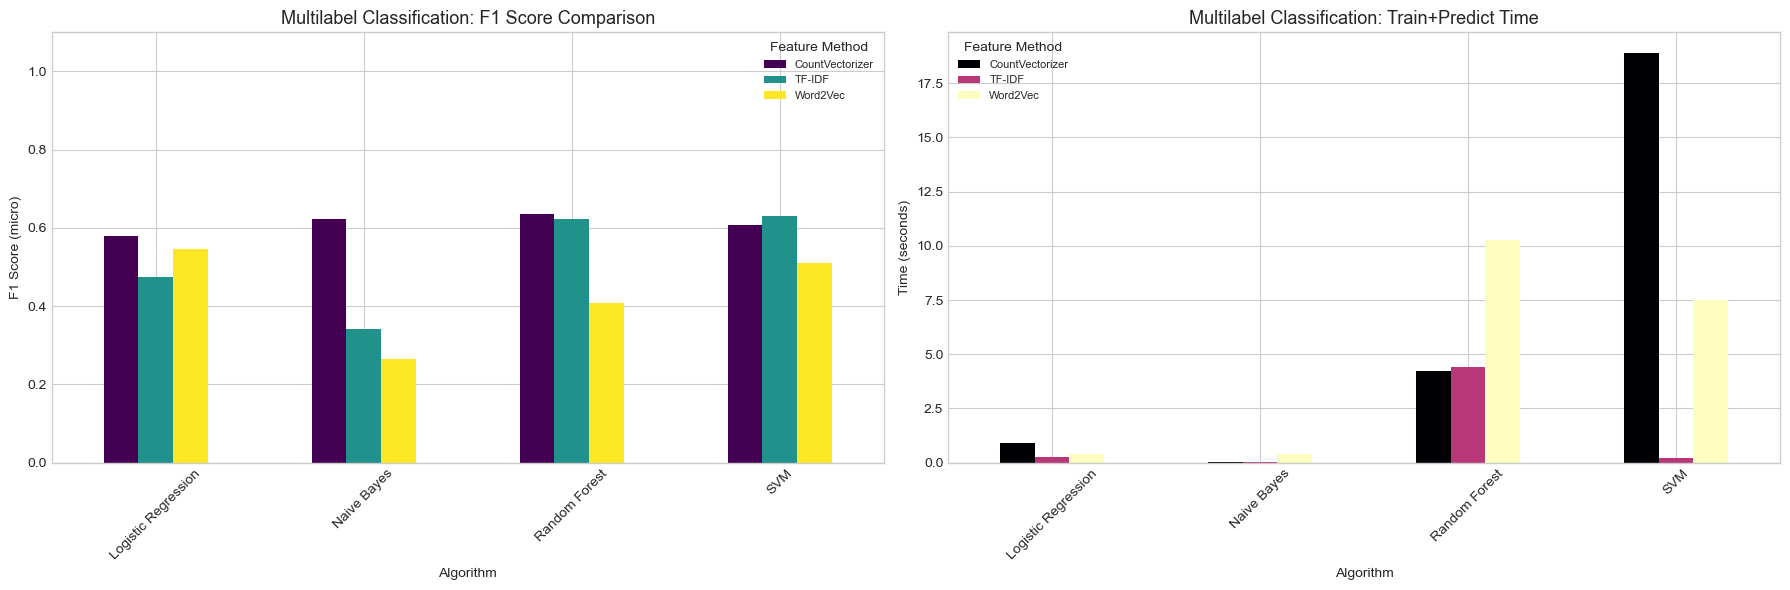

In [15]:
# Visualization: F1 Scores and Timing
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# F1 Score comparison
multilabel_pivot.plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Multilabel Classification: F1 Score Comparison', fontsize=13)
axes[0].set_xlabel('Algorithm')
axes[0].set_ylabel('F1 Score (micro)')
axes[0].legend(title='Feature Method', fontsize=8)
axes[0].set_ylim(0, 1.1)
axes[0].tick_params(axis='x', rotation=45)

# Timing comparison
multilabel_time_pivot.plot(kind='bar', ax=axes[1], colormap='magma')
axes[1].set_title('Multilabel Classification: Train+Predict Time', fontsize=13)
axes[1].set_xlabel('Algorithm')
axes[1].set_ylabel('Time (seconds)')
axes[1].legend(title='Feature Method', fontsize=8)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
